# Here we run benchmark causal discovery algorithms on the big ER graph and connectome graph.

In [1]:
import os

# choose the GPU to use
os.environ["CUDA_VISIBLE_DEVICES"] = "3"
# disable preallocation of memory
os.environ["XLA_PYTHON_CLIENT_PREALLOCATE"] = "false"

# pcax
import pcax as px
import pcax.predictive_coding as pxc
import pcax.nn as pxnn
import pcax.functional as pxf
import pcax.utils as pxu

# 3rd party
import jax
from jax import jit
import jax.numpy as jnp
import optax
import numpy as np

import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.auto import tqdm
import torch
import timeit

# own
import causal_helpers
from causal_helpers import simulate_dag, simulate_parameter, simulate_linear_sem, simulate_linear_sem_cyclic
from causal_helpers import load_adjacency_matrix, set_random_seed, plot_adjacency_matrix

# Set random seed
seed = 23
set_random_seed(seed)

# causal libraries
import cdt, castle, dodiscover

# causal algorithms
from dodiscover.toporder import DAS, SCORE, CAM
from dodiscover import make_context

# causal metrics
from cdt.metrics import precision_recall, SHD, SID
from castle.metrics import MetricsDAG
from castle.common import GraphDAG

2024-08-13 01:35:46.277278: W external/xla/xla/service/gpu/nvptx_compiler.cc:760] The NVIDIA driver's CUDA version is 12.2 which is older than the ptxas CUDA version (12.5.40). Because the driver is older than the ptxas version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.
Detecting CUDA device(s) : [3]


## Load the actual connectome data

In [2]:
# load the weighted adjacency matrices for ER and connectome

# Specify the folder where the adjacency matrices were saved
folder = './data/'

# Example usage to load the saved adjacency matrices
G_A_init_t_ordered_adj_matrix = load_adjacency_matrix(os.path.join(folder, 'G_A_init_t_ordered_adj_matrix.npy'))
G_A_init_t_ordered_dag_adj_matrix = load_adjacency_matrix(os.path.join(folder, 'G_A_init_t_ordered_dag_adj_matrix.npy'))
ER = load_adjacency_matrix(os.path.join(folder, 'ER_adj_matrix.npy'))
ER_dag = load_adjacency_matrix(os.path.join(folder, 'ER_dag_adj_matrix.npy'))

# Change name of the connectome adjacency matrix to C and C_dag
C = G_A_init_t_ordered_adj_matrix
C_dag = G_A_init_t_ordered_dag_adj_matrix

# Now ensure that both DAG adjacency matrices are binary, if they aren't already
ER_dag_bin = (ER_dag != 0).astype(int)
C_dag_bin = (C_dag != 0).astype(int)

ER_true = ER_dag_bin
C_true = C_dag_bin

Adjacency matrix loaded from ./data/G_A_init_t_ordered_adj_matrix.npy
Adjacency matrix loaded from ./data/G_A_init_t_ordered_dag_adj_matrix.npy
Adjacency matrix loaded from ./data/ER_adj_matrix.npy
Adjacency matrix loaded from ./data/ER_dag_adj_matrix.npy


## Create data to debug and implement the pcax version of NOTEARS

In [3]:
# actual data
#B_true = simulate_dag(d=100, s0=400, graph_type='ER') # ER4
# debugging data
#B_true = simulate_dag(d=10, s0=20, graph_type='ER') # ER2


#B_true = C_dag_bin # if you want to use the connectome-based DAG # best performance so far with 200,000 samples: 0.06 
#B_true = ER_dag_bin # if you want to use the ER-based DAG


#B_true = simulate_dag(d=50, s0=100, graph_type='ER') # ER2
#B_true = simulate_dag(d=100, s0=200, graph_type='ER') # ER2
#B_true = simulate_dag(d=279, s0=558, graph_type='ER') # ER2

# create equivalent ER4 graphs
B_true = simulate_dag(d=279, s0=1116, graph_type='ER') # ER4

# create simple data using simulate_dag method from causal_helpers with expected number of edges (s0) and number of nodes (d)
#B_true = simulate_dag(d=100, s0=199, graph_type='ER') # we use p≈0.040226 for the connectome-based ER_dag graph. This means that the expected number of edges is 0.040226 * d * (d-1) / 2
# examples: d=50 -> s0=49 (works), d=100 -> s0=199, d=200 -> s0=800
W_true = simulate_parameter(B_true)

# sample data from the linear SEM
# actual data
#X = simulate_linear_sem(W_true, n=25000, sem_type='gauss')
# for debugging
#X = simulate_linear_sem(W_true, n=2500, sem_type='gauss')
#X = simulate_linear_sem(W_true, n=6250, sem_type='gauss')
#X = simulate_linear_sem(W_true, n=50000, sem_type='gauss')
X = simulate_linear_sem(W_true, n=200000, sem_type='gauss') # 1000*(279**2)/(20**2) = 194602

# now standardized data, where each variable is normalized to unit variance
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_std = scaler.fit_transform(X)

# NOTE: you may not write positional arguments after keyword arguments. 
# That is, the values that you are passing positionally have to come first!

# create a dataset using the simulated data
# NOTE: NOTEARS paper uses n=1000 for graph with d=20.
# NOTE: d... number of nodes, p=d^2... number of parameters, n... number of samples. Then: comparing p1=d1^2 vs p2=d2^2 we have that: n1/p1 must be equal to n2/p2
# Thus we have n2 = n1 * p2 / p1. For the case of d2=100 we have that n2 = (n1*p2)/p1 = 1000*(100^2)/(20^2) = 25000 
# we should expect to use that many samples actually to be able to learn the graph in a comparable way.
#dataset = IIDSimulation(W=W_true, n=25000, method='linear', sem_type='gauss')
#true_dag, X = dataset.B, dataset.X

In [4]:
print(np.sum(B_true))

1116.0


## Implement the PCAX version of NOTEARS ##

In [5]:
# v1: single vode
class Complete_Graph(pxc.EnergyModule):
    def __init__(self, input_dim: int, n_nodes: int, has_bias: bool = False) -> None:
        super().__init__()

        self.input_dim = px.static(input_dim)  # Ensure input_dim is static
        self.n_nodes = px.static(n_nodes)  # Keep n_nodes as a static value
        self.has_bias = has_bias

        # Initialize a single linear layer for the weights and wrap it in a list
        self.layers = [pxnn.Linear(n_nodes * input_dim, n_nodes * input_dim, bias=has_bias)]
        
        # Zero out the diagonal weights to avoid self-loops
        weight_matrix = self.layers[0].nn.weight.get()
        weight_matrix = weight_matrix.reshape(n_nodes, input_dim, n_nodes, input_dim)
        for i in range(n_nodes):
            weight_matrix = weight_matrix.at[i, :, i, :].set(jnp.zeros((input_dim, input_dim)))
        self.layers[0].nn.weight.set(weight_matrix.reshape(n_nodes * input_dim, n_nodes * input_dim))

        # Initialize vodes as a list containing a single matrix
        self.vodes = [pxc.Vode((n_nodes, input_dim))]

    def freeze_nodes(self, freeze=True):
        self.vodes[0].h.frozen = freeze

    def are_vodes_frozen(self):
        """Check if all vodes in the model are frozen."""
        return self.vodes[0].h.frozen
    
    def get_W(self):
        """This function returns the weighted adjacency matrix based on the linear layer in the model."""
        W = self.layers[0].nn.weight.get()
        W_T = W.T
        return W_T

    def __call__(self, x=None):
        n_nodes = self.n_nodes.get()
        input_dim = self.input_dim.get()
        if x is not None:
            # print the shape of x before reshaping when x is not None
            #print("The shape of x before reshaping when x is not None: ", x.shape)

            # Initialize nodes with given data
            reshaped_x = x.reshape(n_nodes, input_dim)

            # print the shape of reshaped_x when x is not None
            #print("The shape of reshaped_x when x is not None: ", reshaped_x.shape)

            self.vodes[0](reshaped_x)
        else:
            # Perform forward pass using stored values
            #x_ = self.vodes[0].get('h').reshape(n_nodes * input_dim, 1)

            x_ = self.vodes[0].get('h')
            # print the shape of x_ when x is None before reshaping
            #print("The shape of x_ when x is None before reshaping: ", x_.shape)

            x_ = x_.reshape(n_nodes * input_dim, 1)
            # print the shape of x_ when x is None after reshaping
            #print("The shape of x_ when x is None after reshaping: ", x_.shape)

            # Perform the matrix-matrix multiplication
            #output = self.layers[0](x_).reshape(n_nodes, input_dim)

            output = self.layers[0](x_)
            # print the shape of output before reshaping
            #print("The shape of output before reshaping: ", output.shape)
            #output = output.reshape(n_nodes, input_dim)
            # print the shape of output after reshaping
            #print("The shape of output after reshaping: ", output.shape)

            # Set the new values in vodes
            self.vodes[0](output)

        # Return the output directly
        return self.vodes[0].get('h')

# Usage
input_dim = 1
n_nodes = X.shape[1]
model = Complete_Graph(input_dim, n_nodes, has_bias=False)

# Get weighted adjacency matrix
W = model.get_W()
print(W)
print()
print(W.shape)
print(model)


# Freezing all nodes
model.freeze_nodes(freeze=True)

# Check if all nodes are frozen
print(model.are_vodes_frozen())

# Unfreezing all nodes
model.freeze_nodes(freeze=False)

# Check if all nodes are frozen
print(model.are_vodes_frozen())

[[ 0.          0.01092721  0.01375564 ... -0.05912329 -0.03491929
  -0.05615176]
 [-0.00325387  0.         -0.03913737 ... -0.04371084  0.00356475
  -0.04321826]
 [ 0.04780662 -0.03505114  0.         ...  0.04649661  0.0211775
  -0.02769883]
 ...
 [ 0.05908186 -0.00479027  0.01583325 ...  0.         -0.05654658
  -0.01286811]
 [ 0.04298096  0.0046092  -0.0401537  ... -0.02880888  0.
   0.04958221]
 [-0.02614293  0.01289225 -0.05840609 ...  0.03585604  0.02779448
   0.        ]]

(279, 279)
(Complete_Graph):
  .has_bias: False
  .layers[0].nn.weight: LayerParam([279,279], float32)
  .vodes[0].h: VodeParam(None)
  .vodes[0].cache: Cache(params=None)
True
False


In [6]:
# TODO: make the below params global or input to the functions in which it is used.
#w_learning_rate = 5e-3 # works well
#w_learning_rate = 5e-2
w_learning_rate = 1e-2
#w_learning_rate = 5e-3
h_learning_rate = 5e-4
T = 1
nm_epochs = 200
#nm_epochs = 500
#nm_epochs = 1500

# small graphs
#batch_size = 64
#lam_h = 150 # works well for small graphs

# large graphs
#batch_size = 2048 # works well for 279 nodes examples
#batch_size = 4096 # works well for 279 nodes examples
batch_size = 8192 # works well for 279 nodes examples
#lam_h = 100 # works well for 279 nodes examples
#lam_h = 1e1 # works well for 279 nodes vanilla ER4 
#lam_h = 1e-5 # works well for 279 nodes vanilla ER4
lam_h = 1e2

#lam_l1 = 1e-5 #  works well for 279 nodes examples
#lam_l1 = 1e-1 # works well for ER2
#lam_l1 = 1e-2 # works well for ER4
#lam_l1 = 1e4 # good for ER with similar # nodes (num_nodes) and edges (num_edges) as original chemical synapse connectome graph: graph A_init_t_ordered
#lam_l1 = 1e-10 #1e2 gives 0 edges for A_init_t_ordered ER graph
lam_l1 = 1e-2

In [7]:
# Training and evaluation functions
@pxf.vmap(pxu.Mask(pxc.VodeParam | pxc.VodeParam.Cache, (None, 0)), in_axes=(0,), out_axes=0)
def forward(x, *, model: Complete_Graph):
    return model(x)

@pxf.vmap(pxu.Mask(pxc.VodeParam | pxc.VodeParam.Cache, (None, 0)), out_axes=(None, 0), axis_name="batch")
def energy(*, model: Complete_Graph):
    x_ = model(None)
    
    W = model.get_W()
    d = model.n_nodes.get()

    # compute the PC energy term (loss)
    loss = jax.lax.pmean(model.energy(), "batch")

    # compute L1 regularization term of W
    l1_reg = jnp.sum(jnp.abs(W))

    # compute L2 regularization term of W
    l2_reg = jnp.sum(W**2)

    # compute the DAG regularization term of W
    h_reg = jnp.trace(jax.scipy.linalg.expm(W * W)) - d # where W * W is the Hadamard product of W with itself
    
    #obj = loss + lam_h * h_reg + lam_l1 * l1_reg + lam_l2 * l2_reg
    obj = loss + lam_h * h_reg + lam_l1 * l1_reg
    
    return obj, x_

@pxf.jit(static_argnums=0)
def train_on_batch(T: int, x: jax.Array, *, model: Complete_Graph, optim_w: pxu.Optim, optim_h: pxu.Optim):

    print("Training!")  # this will come in handy later

    # This only sets an internal flag to be "train" (instead of "eval")
    model.train()

    # freeze nodes at the start of training
    model.freeze_nodes(freeze=True)

    # init step
    with pxu.step(model, pxc.STATUS.INIT, clear_params=pxc.VodeParam.Cache):
        forward(x, model=model)


    """
    # The following code might not be needed as we are keeping the vodes frozen at all times
    # Reinitialize the optimizer state between different batches
    optim_h.init(pxu.Mask(pxc.VodeParam)(model))

    for _ in range(T):
        with pxu.step(model, clear_params=pxc.VodeParam.Cache):
            (e, x_), g = pxf.value_and_grad(
                pxu.Mask(pxu.m(pxc.VodeParam).has_not(frozen=True), [False, True]),
                has_aux=True
            )(energy)(model=model)
        optim_h.step(model, g["model"], True)
    """
        
    with pxu.step(model, clear_params=pxc.VodeParam.Cache):
        _, g = pxf.value_and_grad(pxu.Mask(pxnn.LayerParam, [False, True]), has_aux=True)(energy)(model=model)
        
        # Zero out the diagonal gradients using jax.numpy.fill_diagonal
        weight_grads = g["model"].layers[0].nn.weight.get()
        weight_grads = jax.numpy.fill_diagonal(weight_grads, 0.0, inplace=False)
        # print the grad values using the syntax jax.debug.print("🤯 {x} 🤯", x=x)
        #jax.debug.print("{weight_grads}", weight_grads=weight_grads)
        g["model"].layers[0].nn.weight.set(weight_grads)

    optim_w.step(model, g["model"])

    with pxu.step(model, clear_params=pxc.VodeParam.Cache):
        forward(None, model=model)
        e = model.energy() # this returns energy per sample in the batch
        e_batch = e.mean() # this returns the average energy per sample in the batch

    # unfreeze nodes at the end of training
    model.freeze_nodes(freeze=False)
    
    return e_batch

def train(dl, T, *, model: Complete_Graph, optim_w: pxu.Optim, optim_h: pxu.Optim):
    batch_energies = []
    for batch in dl:

        e_batch = train_on_batch(T, batch, model=model, optim_w=optim_w, optim_h=optim_h)
        batch_energies.append(e_batch)

    W = model.get_W()

    # compute epoch energy
    epoch_energy = jnp.mean(jnp.array(batch_energies))
    return W, epoch_energy

In [8]:
@jit
def MAE(W_true, W):
    """This function returns the Mean Absolute Error for the difference between the true weighted adjacency matrix W_true and th estimated one, W."""
    MAE_ = jnp.mean(jnp.abs(W - W_true))
    return MAE_

def compute_binary_adjacency(W, threshold=0.3):
    """
    Compute the binary adjacency matrix by thresholding the input matrix.

    Args:
    - W (array-like): The weighted adjacency matrix (can be a JAX array or a NumPy array).
    - threshold (float): The threshold value to determine the binary matrix. Default is 0.3.

    Returns:
    - B_est (np.ndarray): The binary adjacency matrix where each element is True if the corresponding 
                          element in W is greater than the threshold, otherwise False.
    """
    # Convert JAX array to NumPy array if necessary
    if isinstance(W, jnp.ndarray):
        W = np.array(W)

    # Compute the binary adjacency matrix
    B_est = np.array(np.abs(W) > threshold)
    
    return B_est

In [9]:
# for reference compute the MAE, SID, and SHD between the true adjacency matrix and an all-zero matrix and then print it
# this acts as a baseline for the MAE, SID, and SHD similar to how 1/K accuracy acts as a baseline for classification tasks where K is the number of classes
W_zero = np.zeros_like(W_true)
print("MAE between the true adjacency matrix and an all-zero matrix: ", MAE(W_true, W_zero))
print("SHD between the true adjacency matrix and an all-zero matrix: ", SHD(B_true, compute_binary_adjacency(W_zero)))
#print("SID between the true adjacency matrix and an all-zero matrix: ", SID(W_true, W_zero))

MAE between the true adjacency matrix and an all-zero matrix:  0.018386086
SHD between the true adjacency matrix and an all-zero matrix:  1116.0


In [10]:
class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, X):
        self.X = X

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx]

# This is a simple collate function that stacks numpy arrays used to interface
# the PyTorch dataloader with JAX. In the future we hope to provide custom dataloaders
# that are independent of PyTorch.
def numpy_collate(batch):
    if isinstance(batch[0], np.ndarray):
        return np.stack(batch)
    elif isinstance(batch[0], (tuple, list)):
        transposed = zip(*batch)
        return [numpy_collate(samples) for samples in transposed]
    else:
        return np.array(batch)

# The dataloader assumes cuda is being used, as such it sets 'pin_memory = True' and
# 'prefetch_factor = 2'. Note that the batch size should be constant during training, so
# we set 'drop_last = True' to avoid having to deal with variable batch sizes.
class TorchDataloader(torch.utils.data.DataLoader):
    def __init__(
        self,
        dataset,
        batch_size=1,
        shuffle=None,
        sampler=None,
        batch_sampler=None,
        num_workers=1,
        pin_memory=True,
        timeout=0,
        worker_init_fn=None,
        persistent_workers=True,
        prefetch_factor=2,
    ):
        super(self.__class__, self).__init__(
            dataset,
            batch_size=batch_size,
            shuffle=shuffle,
            sampler=sampler,
            batch_sampler=batch_sampler,
            num_workers=num_workers,
            collate_fn=numpy_collate,
            pin_memory=pin_memory,
            drop_last=True if batch_sampler is None else None,
            timeout=timeout,
            worker_init_fn=worker_init_fn,
            persistent_workers=persistent_workers,
            prefetch_factor=prefetch_factor,
        )


# Create the custom dataset
dataset = CustomDataset(X)
# Create the custom dataset with standardized data
dataset_std = CustomDataset(X_std)

# Create the dataloader
#dl = TorchDataloader(dataset, batch_size=batch_size, shuffle=True)
######## OR ########
dl = TorchDataloader(dataset_std, batch_size=batch_size, shuffle=True)

In [11]:
# Initialize the model and optimizers
with pxu.step(model, pxc.STATUS.INIT, clear_params=pxc.VodeParam.Cache):
    forward(jnp.zeros((batch_size, model.n_nodes.get())), model=model)
    optim_h = pxu.Optim(optax.sgd(h_learning_rate), pxu.Mask(pxc.VodeParam)(model))
    #optim_w = pxu.Optim(optax.sgd(w_learning_rate), pxu.Mask(pxnn.LayerParam)(model))
    #optim_w = pxu.Optim(optax.sgd(w_learning_rate, momentum=0.95), pxu.Mask(pxnn.LayerParam)(model))
    #optim_w = pxu.Optim(optax.adamw(w_learning_rate, weight_decay=5e-2), pxu.Mask(pxnn.LayerParam)(model))
    optim_w = pxu.Optim(optax.adamw(w_learning_rate), pxu.Mask(pxnn.LayerParam)(model))

# Initialize lists to store differences and energies
MAEs = []
SHDs = []
energies = []

# Calculate the initial MAE, SID, and SHD
MAE_init = MAE(W_true, model.get_W())
print(f"Start difference (cont.) between W_true and W_init: {MAE_init:.4f}")

SHD_init = SHD(B_true, compute_binary_adjacency(model.get_W()))
print(f"Start SHD between W_true and W_init: {SHD_init:.4f}")

# print the values of the diagonal of the initial W
print("The diagonal of the initial W: ", jnp.diag(model.get_W()))

# Start timing
start_time = timeit.default_timer()

# Training loop
with tqdm(range(nm_epochs), position=0, leave=True) as pbar:
    for epoch in pbar:
        # Train for one epoch using the dataloader
        W, epoch_energy = train(dl, T=T, model=model, optim_w=optim_w, optim_h=optim_h)
        
        # Calculate the metrics and store them
        W = np.array(W)
        MAEs.append(float(MAE(W_true, W)))
        SHDs.append(float(SHD(B_true, compute_binary_adjacency(W))))
        energies.append(float(epoch_energy))
        
        # Update progress bar with the current status
        pbar.set_description(f"MAE {MAEs[-1]:.4f}, SHD {SHDs[-1]:.4f} || Energy {energies[-1]:.4f}")

# End timing
end_time = timeit.default_timer()

# Print the average time per epoch
average_time_per_epoch = (end_time - start_time) / nm_epochs
print(f"An epoch (with compiling and testing) took on average: {average_time_per_epoch:.4f} seconds")
# print the values of the diagonal of the final W
print("The diagonal of the final W: ", jnp.diag(model.get_W()))

Start difference (cont.) between W_true and W_init: 0.0479
Start SHD between W_true and W_init: 1116.0000
The diagonal of the initial W:  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


  0%|          | 0/200 [00:00<?, ?it/s]

os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.


Training!
An epoch (with compiling and testing) took on average: 1.8397 seconds
The diagonal of the final W:  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


In [12]:
print(model)
print()
with pxu.step(model, clear_params=pxc.VodeParam.Cache):
    _, g = pxf.value_and_grad(pxu.Mask(pxnn.LayerParam, [False, True]), has_aux=True)(energy)(model=model)
    print(g["model"])

(Complete_Graph):
  .has_bias: False
  .layers[0].nn.weight: LayerParam([279,279], float32)
  .vodes[0].h: VodeParam([8192,279,1], float32)
  .vodes[0].cache: Cache(params=None)

(Complete_Graph):
  .layers[0].nn.weight: LayerParam([279,279], float32)


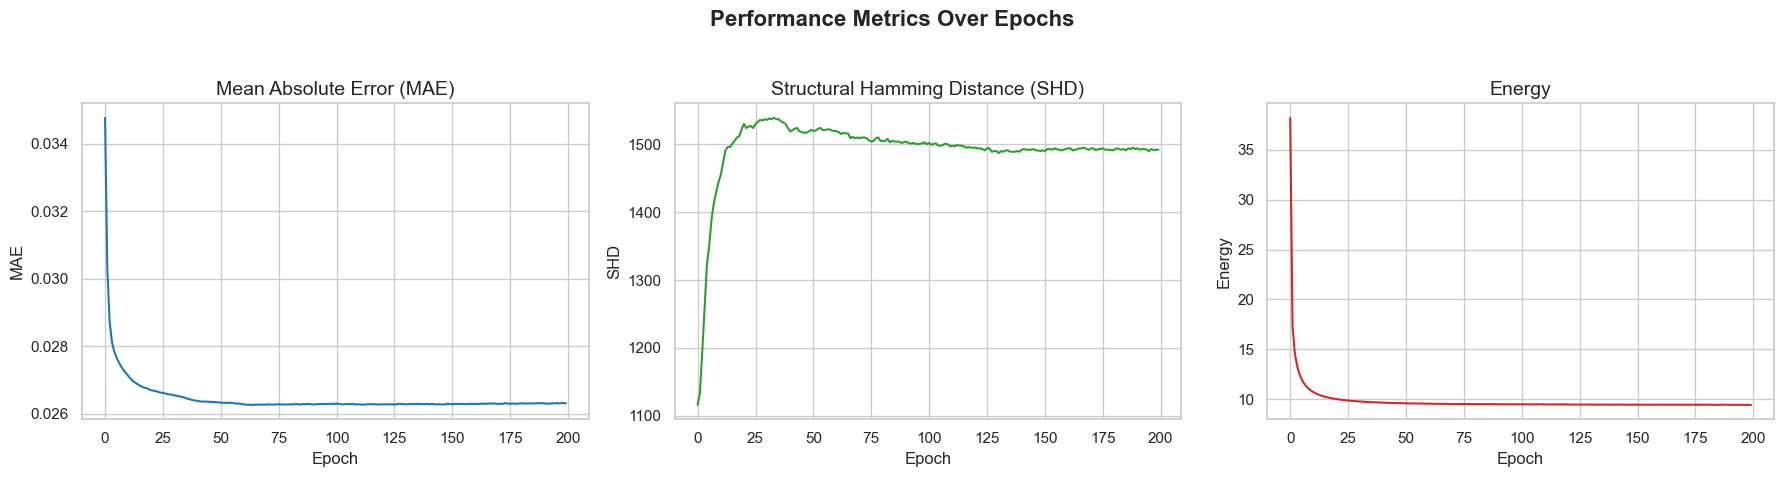

In [13]:
# Set the style and color palette
sns.set(style="whitegrid")
palette = sns.color_palette("tab10")

# Create a figure and axis with a 1x3 layout for side-by-side plots
fig, axs = plt.subplots(1, 3, figsize=(18, 5))  # Adjusting layout to 1 row and 3 columns
fig.suptitle('Performance Metrics Over Epochs', fontsize=16, weight='bold')

# Plot the MAE
sns.lineplot(x=range(nm_epochs), y=MAEs, ax=axs[0], color=palette[0])
axs[0].set_title("Mean Absolute Error (MAE)", fontsize=14)
axs[0].set_xlabel("Epoch", fontsize=12)
axs[0].set_ylabel("MAE", fontsize=12)
axs[0].grid(True)

# Plot the SHD
sns.lineplot(x=range(nm_epochs), y=SHDs, ax=axs[1], color=palette[2])
axs[1].set_title("Structural Hamming Distance (SHD)", fontsize=14)
axs[1].set_xlabel("Epoch", fontsize=12)
axs[1].set_ylabel("SHD", fontsize=12)
axs[1].grid(True)

# Plot the Energy
sns.lineplot(x=range(nm_epochs), y=energies, ax=axs[2], color=palette[3])
axs[2].set_title("Energy", fontsize=14)
axs[2].set_xlabel("Epoch", fontsize=12)
axs[2].set_ylabel("Energy", fontsize=12)
axs[2].grid(True)

# Improve layout and show the plot
plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # Adjust layout to fit the suptitle
plt.show()

In [14]:
# Now use a threshold of 0.3 to binarize the weighted adjacency matrix W
W_est = np.array(model.get_W())
B_est = compute_binary_adjacency(W_est, threshold=0.3)

<Figure size 1200x600 with 0 Axes>

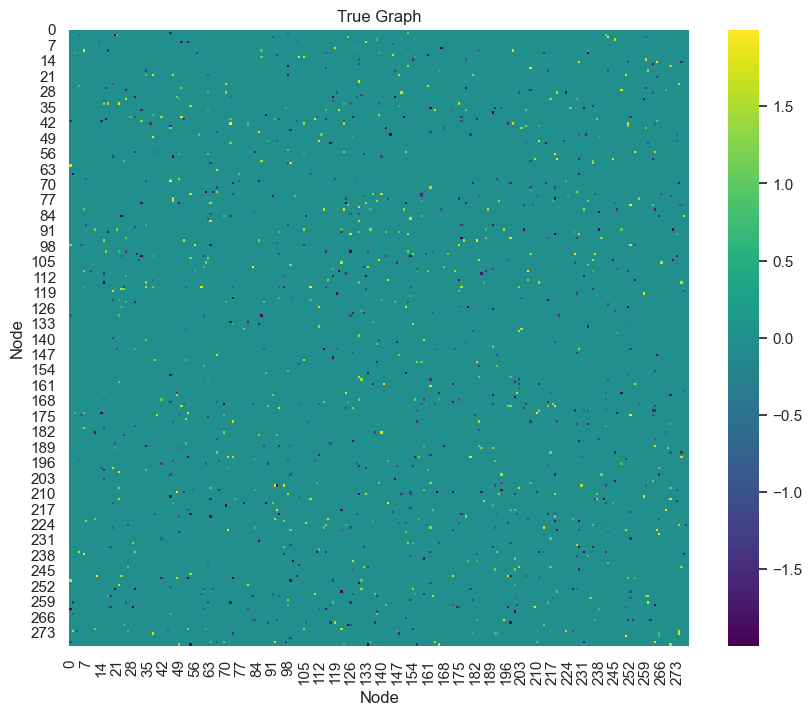

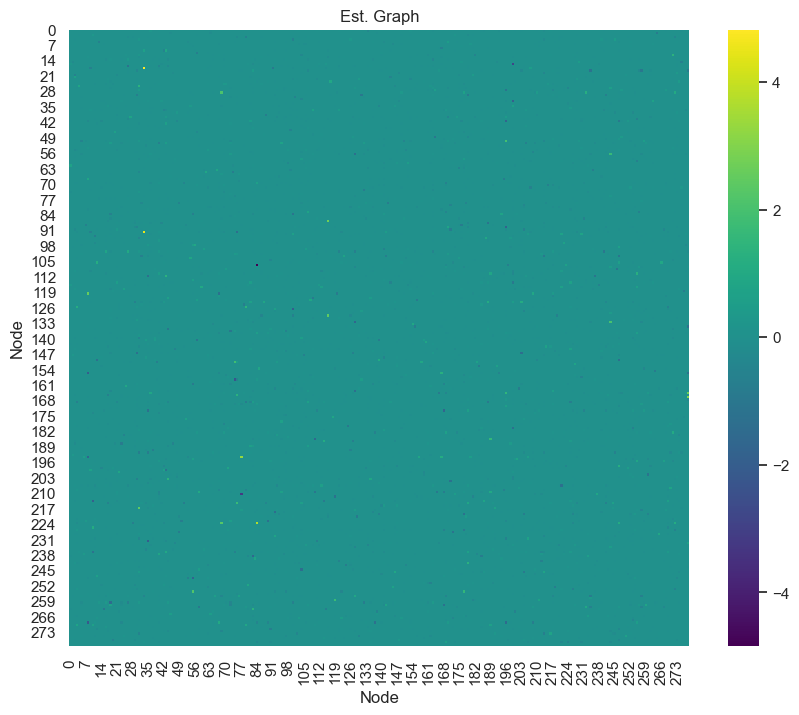

In [15]:
# now show the adjacency matrix of the true graph and the estimated graph side by side
plt.figure(figsize=(12, 6))

plot_adjacency_matrix(W_true, title='True Graph')

plot_adjacency_matrix(W_est, title='Est. Graph')

In [16]:
# print first 5 rows and columsn of W_est
print(W_est[:5, :5])

[[ 0.0000000e+00  1.4706679e-03  1.8480222e-03 -8.9950219e-05
  -2.4478824e-05]
 [-9.3293434e-04  0.0000000e+00  6.0179835e-04 -1.2622966e-04
  -5.0385628e-05]
 [ 1.8916721e-03  2.3527984e-03  0.0000000e+00 -3.6996990e-03
  -8.6578662e-03]
 [ 7.7423011e-04 -3.5292626e-04  3.5027033e-03  0.0000000e+00
  -1.6947062e-04]
 [-6.8355835e-04  2.5717821e-02 -2.4852538e-02  1.6042610e-03
   0.0000000e+00]]


<Figure size 1200x600 with 0 Axes>

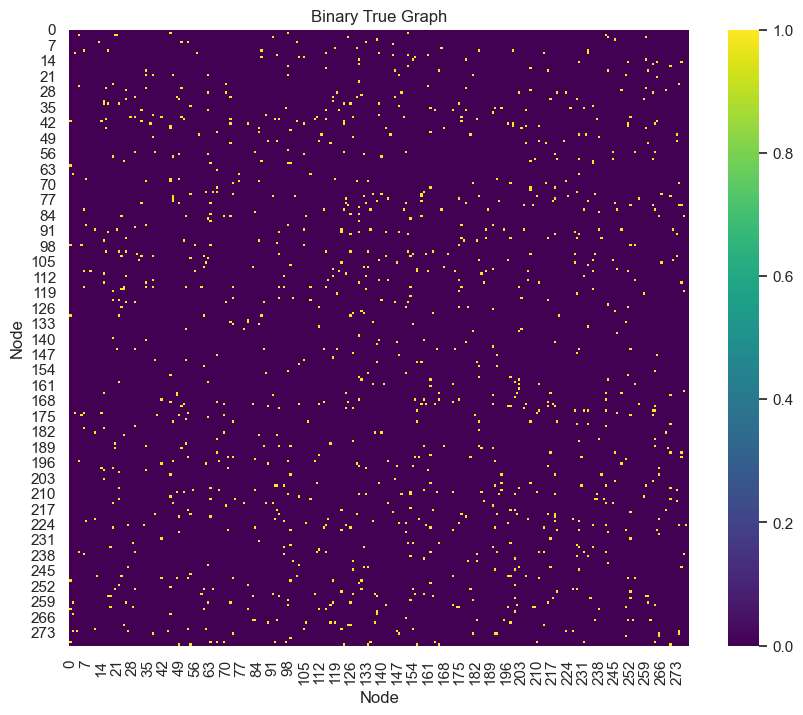

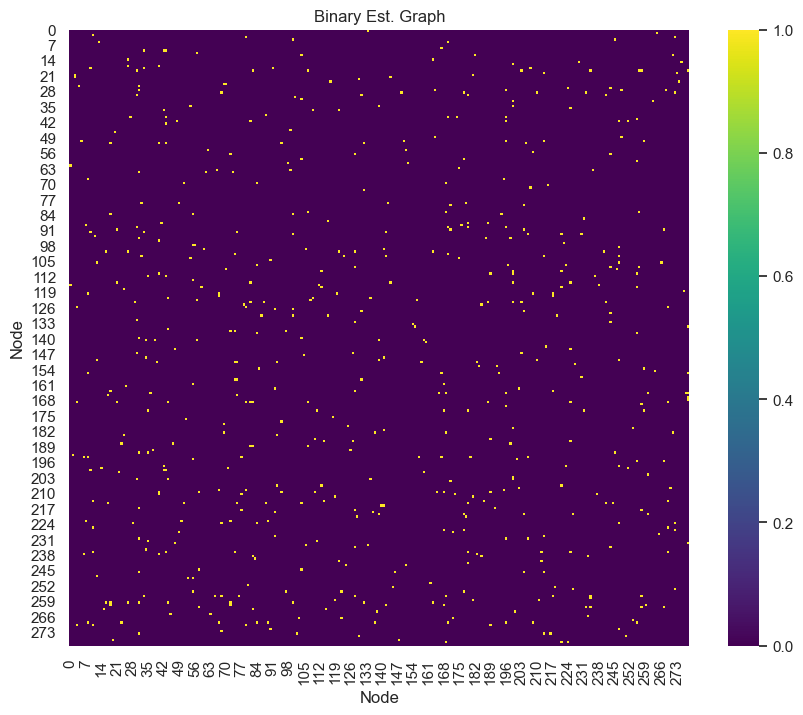

In [17]:
# now show the adjacency matrix of the true graph and the estimated graph side by side
plt.figure(figsize=(12, 6))

plot_adjacency_matrix(B_true, title='Binary True Graph')

plot_adjacency_matrix(B_est, title='Binary Est. Graph')

In [18]:
print(np.sum(B_est))
print(np.sum(B_true))

606
1116.0


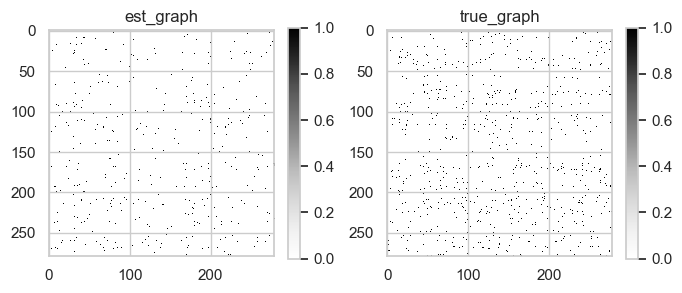

{'fdr': 0.8102, 'tpr': 0.103, 'fpr': 0.013, 'shd': 1287, 'nnz': 606, 'precision': 0.1898, 'recall': 0.103, 'F1': 0.1336, 'gscore': 0.0}


DataFrame.applymap has been deprecated. Use DataFrame.map instead.
DataFrame.applymap has been deprecated. Use DataFrame.map instead.
DataFrame.applymap has been deprecated. Use DataFrame.map instead.


In [19]:
# plot est_dag and true_dag
GraphDAG(B_est, B_true)
# calculate accuracy
met_pcax = MetricsDAG(B_est, B_true)
print(met_pcax.metrics)

In [ ]:
from castle.algorithms import ICALiNGAM, DirectLiNGAM

In [ ]:
directlingam = DirectLiNGAM()
directlingam.learn(X)

In [ ]:
icalingam = ICALiNGAM(max_iter=5000) # default max_iter=1000 does not converge
icalingam.learn(X)

In [ ]:
# convert X into a pandas dataframe
import pandas as pd
X_df = pd.DataFrame(X)

In [ ]:
from cdt.causality.graph import PC
pc = PC()
pc.create_graph_from_data(X_df)

In [ ]:
# benchmarks that don't work yet 


# benchmark models
das = DAS()
score = SCORE()
cam = CAM()

# convert X into a pandas dataframe
import pandas as pd
X_df = pd.DataFrame(X)
# take only 10000 samples/rows from X
#X_df = pd.DataFrame(X[:10000, :])

context = make_context().variables(data=X_df).build()

# cam.learn_graph(data_df=X_df, context=context)
# score.learn_graph(data_df=X_df, context=context)
# das.learn_graph(data_df=X_df, context=context)

In [ ]:
########################################## MISC CODE #########################################################


# v1: single vode, fast but gives NaNs

class Complete_Graph(pxc.EnergyModule):
    def __init__(self, input_dim: int, n_nodes: int, has_bias: bool = False) -> None:
        super().__init__()

        self.input_dim = px.static(input_dim)  # Ensure input_dim is static
        self.n_nodes = px.static(n_nodes)  # Keep n_nodes as a static value
        self.has_bias = has_bias

        # Initialize a single linear layer for the weights and wrap it in a list
        self.layers = [pxnn.Linear(n_nodes * input_dim, n_nodes * input_dim, bias=has_bias)]
        
        # Zero out the diagonal weights to avoid self-loops
        weight_matrix = self.layers[0].nn.weight.get()
        weight_matrix = weight_matrix.reshape(n_nodes, input_dim, n_nodes, input_dim)
        for i in range(n_nodes):
            weight_matrix = weight_matrix.at[i, :, i, :].set(jnp.zeros((input_dim, input_dim)))
        self.layers[0].nn.weight.set(weight_matrix.reshape(n_nodes * input_dim, n_nodes * input_dim))

        # Initialize vodes as a list containing a single matrix
        self.vodes = [pxc.Vode((n_nodes, input_dim))]

    def freeze_nodes(self, freeze=True):
        self.vodes[0].h.frozen = freeze

    def are_vodes_frozen(self):
        """Check if all vodes in the model are frozen."""
        return self.vodes[0].h.frozen
    
    def get_W(self):
        """This function returns the weighted adjacency matrix based on the linear layer in the model."""
        W = self.layers[0].nn.weight.get()  # Get the weight matrix, possibly as a different type
        W = W.numpy()  # Convert to numpy array if necessary
        W_T = W.T  # Transpose the matrix if needed
        return W_T

    
    def __call__(self, x=None):
        n_nodes = self.n_nodes.get()
        input_dim = self.input_dim.get()
        if x is not None:
            # print the shape of x before reshaping when x is not None
            print("The shape of x before reshaping when x is not None: ", x.shape)

            # Initialize nodes with given data
            reshaped_x = x.reshape(n_nodes, input_dim)

            # print the shape of reshaped_x when x is not None
            print("The shape of reshaped_x when x is not None: ", reshaped_x.shape)

            self.vodes[0](reshaped_x)
        else:
            # Perform forward pass using stored values
            #x_ = self.vodes[0].get('h').reshape(n_nodes * input_dim, 1)

            x_ = self.vodes[0].get('h')
            # print the shape of x_ when x is None before reshaping
            print("The shape of x_ when x is None before reshaping: ", x_.shape)

            #x_ = x_.reshape(n_nodes * input_dim, 1)
            # print the shape of x_ when x is None after reshaping
            #print("The shape of x_ when x is None after reshaping: ", x_.shape)

            # Perform the matrix-matrix multiplication
            #output = self.layers[0](x_).reshape(n_nodes, input_dim)
            
            output = self.layers[0](x_)
            # print the shape of output before reshaping
            print("The shape of output before reshaping: ", output.shape)
            output = output.reshape(n_nodes, input_dim)
            # print the shape of output after reshaping
            print("The shape of output after reshaping: ", output.shape)

            # Set the new values in vodes
            self.vodes[0](output)

        # Return the output directly
        return self.vodes[0].get('h')
    

    # v2: multiple vodes
class Complete_Graph(pxc.EnergyModule):
    def __init__(self, input_dim: int, n_nodes: int, has_bias: bool = False) -> None:
        super().__init__()

        self.input_dim = px.static(input_dim)  # Ensure input_dim is static
        self.n_nodes = px.static(n_nodes)  # Keep n_nodes as a static value
        self.has_bias = has_bias

        # Initialize a single linear layer for the weights and wrap it in a list
        self.layers = [pxnn.Linear(n_nodes * input_dim, n_nodes * input_dim, bias=has_bias)]
        
        # Zero out the diagonal weights to avoid self-loops
        weight_matrix = self.layers[0].nn.weight.get()
        weight_matrix = weight_matrix.reshape(n_nodes, input_dim, n_nodes, input_dim)
        for i in range(n_nodes):
            weight_matrix = weight_matrix.at[i, :, i, :].set(jnp.zeros((input_dim, input_dim)))
        self.layers[0].nn.weight.set(weight_matrix.reshape(n_nodes * input_dim, n_nodes * input_dim))

        # Initialize individual vodes for each node
        self.vodes = [pxc.Vode((input_dim,)) for _ in range(n_nodes)]

    def freeze_nodes(self, freeze=True):
        for vode in self.vodes:
            vode.h.frozen = freeze

    def are_vodes_frozen(self):
        """Check if all vodes in the model are frozen."""
        return all(vode.h.frozen for vode in self.vodes)
    
    def get_W(self):
        """This function returns the weighted adjacency matrix based on the linear layer in the model."""
        W = self.layers[0].nn.weight.get()
        W_T = W.T
        return W_T

    def __call__(self, x=None):
        n_nodes = self.n_nodes.get()
        input_dim = self.input_dim.get()
        if x is not None:
            # Initialize nodes with given data
            reshaped_x = x.reshape(n_nodes, input_dim)
            
            # this is the shape a vode's input when x is not None
            print("The shape of reshaped_x[0] when x is not None is: ", reshaped_x[0].shape)

            for i in range(n_nodes):
                self.vodes[i](reshaped_x[i])

        else:
            x_ = jnp.vstack([vode.get('h') for vode in self.vodes])

            # print the shape of x_ when x is None
            print("The shape of x_ when x is None is: ", x_.shape)

            # Perform the matrix-matrix multiplication
            flattened_x = x_.reshape(n_nodes * input_dim, 1)

            # print the shape of flattened_x when x is None
            print("The shape of flattened_x when x is None is: ", flattened_x.shape)

            output = self.layers[0](flattened_x)

            # print the shape of output when x is None
            print("The shape of output when x is None is: ", output.shape)

            output = output.reshape(n_nodes, input_dim)

            # print the shape of output after reshaping when x is None
            print("The shape of output after reshaping when x is None is: ", output.shape)

            # print the shape of a vodes input when x is not None
            print("The shape of output[0] when x is None is: ", output[0].shape)

            # Set the new values in vodes
            for i in range(n_nodes):
                self.vodes[i](output[i])

        output = jnp.vstack([vode.get('h') for vode in self.vodes])

        # print the shape of the output
        print("The shape of the output is: ", output.shape)

        return output